<a href="https://colab.research.google.com/github/EmilisGit/Vaizdu_apdorojimas/blob/main/vaizdu_atpazinimas_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import cv2 as cv
from PIL import Image
import pillow_heif
import numpy as np
import matplotlib.pyplot as plt

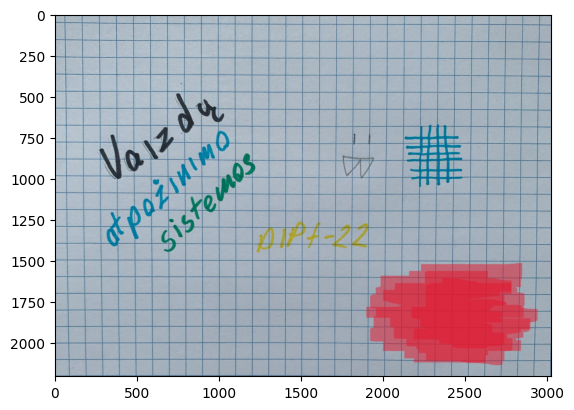

In [36]:
original_bgr = cv.imread("tekstas.jpg")
original_rgb = cv.cvtColor(original_bgr, cv.COLOR_BGR2RGB)

plt.imshow(original_rgb)

##Vaizdo histogramos analizė

Su Python sudarant nespalvoto (angl. grayscale) ir spalvoto vaizdo histogramas nustatykite, kokios vaizdo spalvų pikselių vertės atitinka teksto ir fono regionus (nustatykite slenksčio vertes).

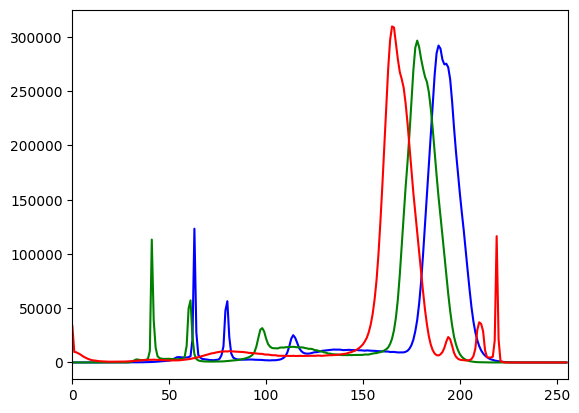

In [37]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv.calcHist([original_bgr],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()


# Iš histogramos, galima pasakyti, kad fonas baltas fonas turi
# pikselių vertes aukštesnes nei 150, ir žemesnes nei ~210

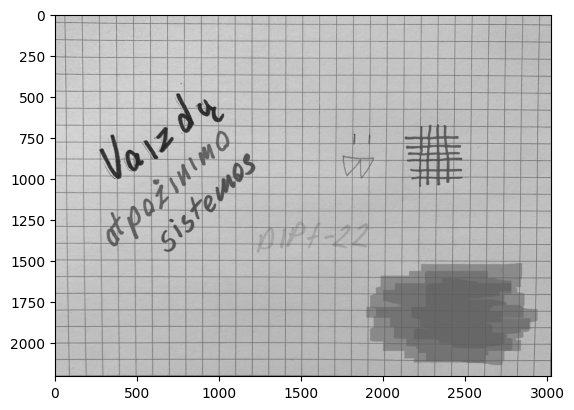

In [38]:
gray = cv.cvtColor(original_bgr, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")
plt.show()

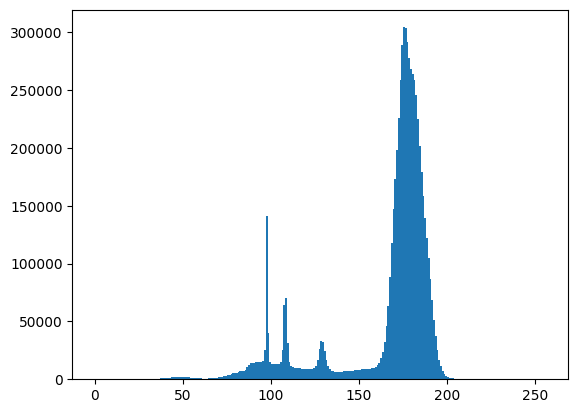

In [45]:
plt.hist(gray.ravel(),bins=256,range=[0,256])
plt.show()

# Pilkos nuotraukos fonas atitinka 160 - 200 pikselių vertes

##Fono atskyrimas nuo teksto

Remdamiesi vaizdo histogramos analize, pašalinkite foną iš paveikslo, tokiu būdu palikite tik teksto regionus. Pritaikykite tris skirtingus metodus (nuoroda su kodu žemiau ir nustatykite reikiamas slenksčio ir f-jų reikšmes):

####a) Nespalvotam vaizdui:

1.   automatinį Otsu
2.   slenksčio.

####b) Spalvotam vaizdui

1.   HSV slenksčio.

Naudokite kodą: https://www.freedomvc.com/index.php/2022/01/17/basic-background-remover-with-opencv/
Daugiau apie slenksčio nustatymą: https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

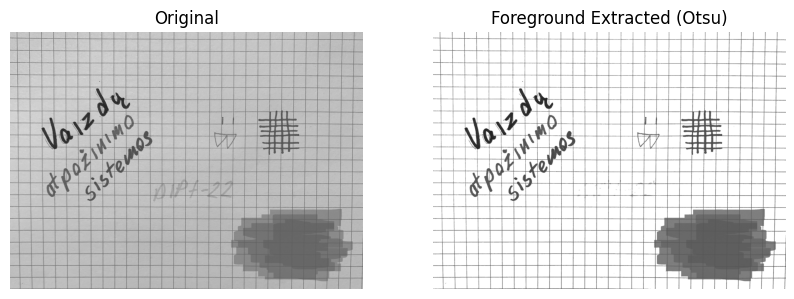

In [64]:
#@title a) 1. Automatinis Otsu

def Otsu_background_remove(gray_image):
    blur = cv.GaussianBlur(gray_image, (5, 5), 0)
    _, binary_mask = cv.threshold(blur, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    mask = binary_mask == 0
    result = np.ones_like(gray_image) * 255
    result[mask] = gray_image[mask]
    return result

result = Otsu_background_remove(gray)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Foreground Extracted (Otsu)")
plt.imshow(result, cmap='gray')
plt.axis('off')

plt.show()

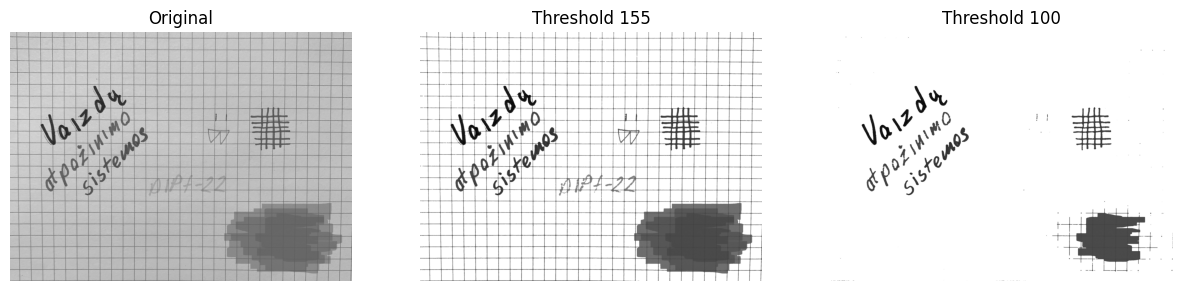

In [101]:
#@title a) 2. Slenksčio

def Threshold_background_remove(img, threshold):

    img_grey = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_grey = cv.medianBlur(img_grey, 7)

    ret,baseline = cv.threshold(img_grey,threshold,255,cv.THRESH_TRUNC)

    ret,background = cv.threshold(baseline,threshold-1,255,cv.THRESH_BINARY)

    ret,foreground = cv.threshold(baseline,threshold-1,255,cv.THRESH_BINARY_INV)

    foreground = cv.bitwise_and(img_grey,img_grey, mask=foreground)

    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    return finalimage

result1 = Threshold_background_remove(original_bgr, 155)
result2 = Threshold_background_remove(original_bgr, 100)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Threshold 155")
plt.imshow(result1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Threshold 100")
plt.imshow(result2, cmap='gray')
plt.axis('off')

plt.show()


(np.float64(-0.5), np.float64(3023.5), np.float64(2204.5), np.float64(-0.5))

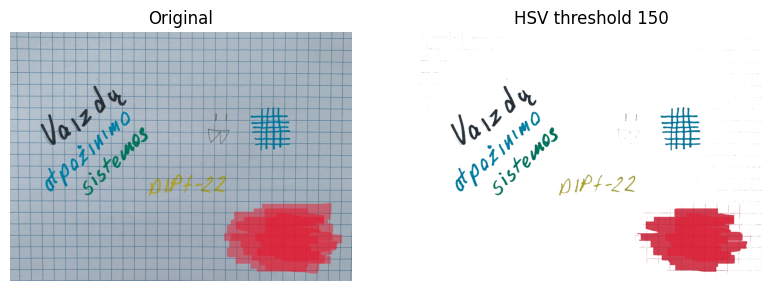

In [109]:
#@title b) 1.HSV slenksčio

def HSV_background_remove(myimage, threshold):
    myimage_hsv = cv.cvtColor(myimage, cv.COLOR_BGR2HSV)

    s = myimage_hsv[:,:,1]
    s = np.where(s < threshold, 0, 1)

    v = (myimage_hsv[:,:,2] + threshold) % 255
    v = np.where(v > threshold, 1, 0)

    # Combine our two masks based on S and V into a single "Foreground"
    foreground = np.where(s+v > 0, 1, 0).astype(np.uint8)  #Casting back into 8bit integer

    background = np.where(foreground==0,255,0).astype(np.uint8) # Invert foreground to get background in uint8
    background = cv.cvtColor(background, cv.COLOR_GRAY2BGR)  # Convert background back into BGR space
    foreground=cv.bitwise_and(myimage,myimage,mask=foreground) # Apply our foreground map to original image
    finalimage = background+foreground # Combine foreground and background

    return finalimage

result = HSV_background_remove(original_bgr, 150)
result_rgb = cv.cvtColor(result, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(original_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("HSV threshold 150")
plt.imshow(result_rgb)
plt.axis('off')


##Fono atskyrimas nuo teksto taikant kraštų aptikimą

Vaizdui su atskirtu tekstu pritaikykite kraštų aptikimo metodus Sobel ir Canny nustatant kuo tinkamesnes šių f-jų reikšmes, kad išskirtumėte kraštus aplink tekstą. Prieš taikant kraštų aptikimo metodus vaizdą paverskite į nespalvotą ir pritaikykite GaussianBlur f-ją.
Naudokite kodą: https://learnopencv.com/edge-detection-using-opencv/
Pasitelkdami aptiktais teksto kraštais, sukurkite vaizdo segmentacijos kaukę, kuri atskirtų tekstą nuo fono.
Panaudokite sukurtą vaizdo segmentacijos kaukę, kad sukurtumėte dvi pradinio vaizdo versijas – vaizdą tik su teksto regionais ir vaizdą tik su fonu (tekstas iškirptas).

(np.float64(-0.5), np.float64(3023.5), np.float64(2204.5), np.float64(-0.5))

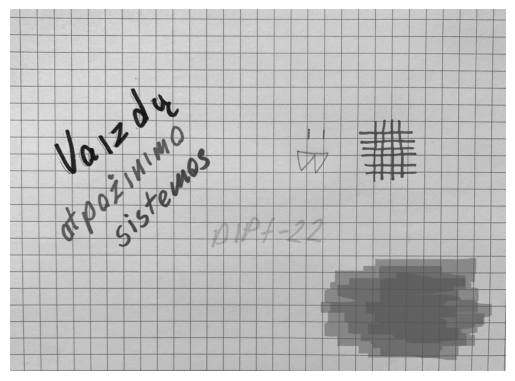

In [201]:
def preprocess_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray, (3, 3), 0)
    return blurred

def sobel_edge_detection(image):
    sobelxy = cv.Sobel(image, cv.CV_8U, 1, 1, ksize=5)
    return sobelxy

def canny_edge_detection(image, threshold1=70, threshold2=160):
    return cv.Canny(image, threshold1, threshold2)

def create_mask_from_edges(edges, kernel_size=5, fill=True):
    # Dilate to connect edges
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    dilated = cv.dilate(edges, kernel, iterations=5)

    return dilated > 150

def apply_mask(image, mask, keep_foreground=True):
    # If keep_foreground, preserve the area under the mask; else remove it
    mask_bool = mask.astype(bool)
    if not keep_foreground:
        mask_bool = ~mask_bool

    result = np.ones_like(image) * 255
    result[mask_bool] = image[mask_bool]
    return result



blurred_image = preprocess_image(original_bgr)
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

(np.float64(-0.5), np.float64(3023.5), np.float64(2204.5), np.float64(-0.5))

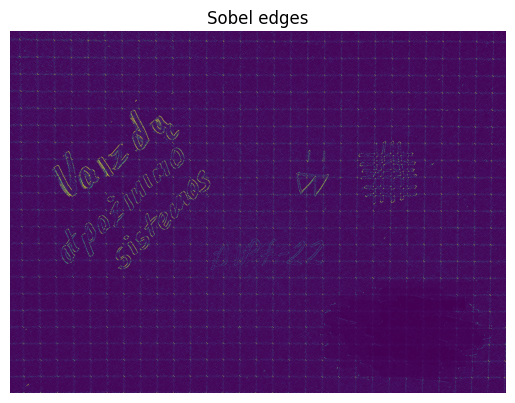

In [202]:
sobel_edges = sobel_edge_detection(blurred_image)
plt.title("Sobel edges")
plt.imshow(sobel_edges)
plt.axis('off')

(np.float64(-0.5), np.float64(3023.5), np.float64(2204.5), np.float64(-0.5))

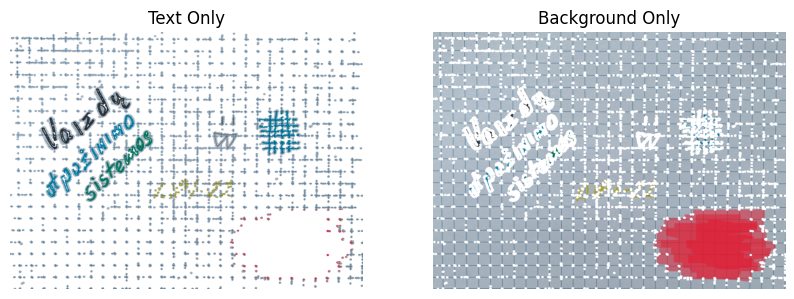

In [206]:
sobel_mask = create_mask_from_edges(sobel_edges, fill=False)
foreground_only = apply_mask(original_bgr, sobel_mask, keep_foreground=True)
background_only = apply_mask(original_bgr, sobel_mask, keep_foreground=False)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Text Only")
plt.imshow(cv.cvtColor(foreground_only, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Background Only")
plt.imshow(cv.cvtColor(background_only, cv.COLOR_BGR2RGB))
plt.axis('off')

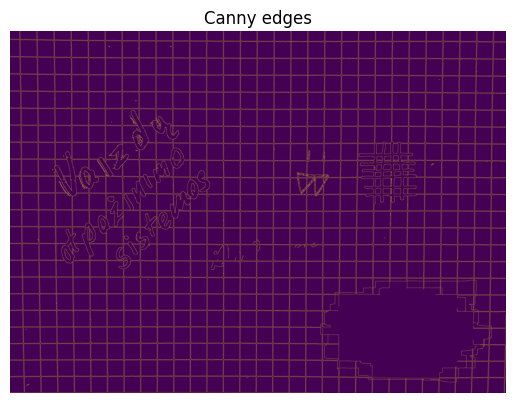

In [207]:
canny_edges = canny_edge_detection(blurred_image, 50, 160)

plt.title("Canny edges")
plt.imshow(canny_edges)
plt.axis('off')

(np.float64(-0.5), np.float64(3023.5), np.float64(2204.5), np.float64(-0.5))

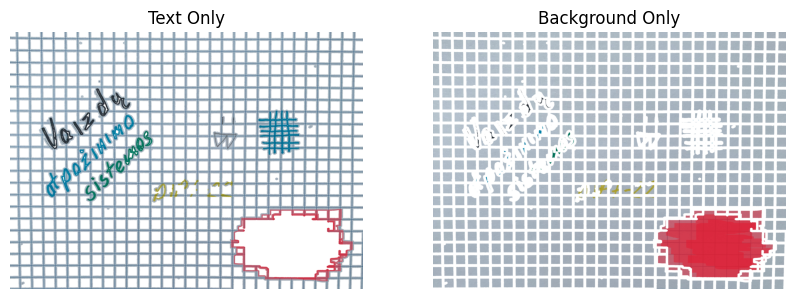

In [208]:
canny_mask = create_mask_from_edges(canny_edges)
foreground_only = apply_mask(original_bgr, canny_mask, keep_foreground=True)
background_only = apply_mask(original_bgr, canny_mask, keep_foreground=False)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Text Only")
plt.imshow(cv.cvtColor(foreground_only, cv.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Background Only")
plt.imshow(cv.cvtColor(background_only, cv.COLOR_BGR2RGB))
plt.axis('off')